In [1]:
import json
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt

# First things first: get USDA codes

In [2]:
#with open("Country Codes.json") as cnt_code:
#    country_codes = json.load(cnt_code)

#with open("Commodity Codes.json") as cmdt_code:
#    cmdty_code = json.load(cmdt_code)

#with open("UnitOFMeasure.json") as unt_measure:
#    measure_unit = json.load(unt_measure)

#country_codes = pd.DataFrame(country_codes)
#cmdty_code = pd.DataFrame(cmdty_code)
#measure_unit = pd.DataFrame(measure_unit)

#country_codes.to_excel("country_codes.xlsx", index=False)
#cmdty_code.to_excel("cmdty_code.xlsx", index=False)
#measure_unit.to_excel("measure_unit.xlsx", index=False)

# Fetching Data

We need 6 years of ESR weekly data. First, a few definitons:

In [ ]:
cotton = 1404
corn = 401
soybeans = 801
all_wheat = 107

API_key = "zPBRirl0J5CXH2zcHC1ibRpRJkGgTBmu6jEkdurZ"
headers = {
    'X-Api-Key': API_key,
    'accept': 'application/json' #specifies I need response in json
}

Defining a function that fetches the data for every year and concatenates everything into a single df. Then, using this function.

In [4]:
def get_ESR_data(api_key, start_year, end_year):
    all_data = []

    for year in range(start_year, end_year + 1):
        url = f"https://api.fas.usda.gov/api/esr/exports/commodityCode/{cotton}/allCountries/marketYear/{year}"
        response = requests.get(url, headers=headers)

        df = pd.DataFrame(response.json())

        all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)

df_totals = get_ESR_data(API_key, 2021, 2026)
df_totals["weekEndingDate"] = pd.to_datetime(df_totals["weekEndingDate"])

In [5]:
exports_CMY = df_totals[["weekEndingDate", "countryCode", "weeklyExports",
                     "grossNewSales", "currentMYNetSales", "nextMYNetSales", "currentMYTotalCommitment", "accumulatedExports" , "outstandingSales"]]
exports_CMY["Cancel"] = exports_CMY["grossNewSales"] - exports_CMY["currentMYNetSales"]
latest = exports_CMY["weekEndingDate"].max()
last_week = exports_CMY[exports_CMY["weekEndingDate"] == latest]

C:\Users\vfernandes\AppData\Local\Temp\ipykernel_26460\1980842712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exports_CMY["Cancel"] = exports_CMY["grossNewSales"] - exports_CMY["currentMYNetSales"]


In [6]:
# check: most recent date
exports_CMY["weekEndingDate"].max().date()

datetime.date(2025, 11, 27)

In [7]:
countries = pd.read_excel("country_codes.xlsx")
countries = countries[["countryCode", "countryDescription"]]
countries["countryDescription"] = countries["countryDescription"].str.strip()
last_week = pd.merge(last_week, countries)

last_week.loc[last_week["countryDescription"] == "CHINA, PEOPLES REPUBLIC OF",
       "countryDescription"] = "CHINA"
last_week.loc[last_week["countryDescription"] == "KOREA, REPUBLIC OF",
       "countryDescription"] = "S. KOREA"

In [8]:
gross_new_sales = f"{last_week['grossNewSales'].sum():,.0f}"
net_new_sales = f"{last_week['currentMYNetSales'].sum():,.0f}"
cancel = f"{last_week['Cancel'].sum():,.0f}"
week_shipments = f"{last_week['weeklyExports'].sum():,.0f}"
NMY_net_new_sales = f"{last_week['nextMYNetSales'].sum():,.0f}"
latest_formated = exports_CMY["weekEndingDate"].max().date()

# Export Sales Treemap

In [9]:
fig = px.treemap(last_week, path=["countryDescription"], values="currentMYNetSales",
                 color= "currentMYNetSales",
                 color_continuous_scale="Oranges",
                 title=f"<b>US Cotton Sales (running bales) - Week Ending {latest_formated}.</b><br>"
                 f"<sup><b>Net New CMY Sales</b>: {net_new_sales};" 
                 f"<b> Shipments</b>: {week_shipments};"
                 f"<b> Cancelations</b>: {cancel};"
                 f"<b> Next MY Sales</b>: {NMY_net_new_sales}. </sup>")
fig.update_layout(width=900, height=700,
                  title_font=dict(size=19),
                  title_x=0.5)
fig.update_traces(texttemplate="%{label}<br>%{value:,.0f}")
fig.update_coloraxes(showscale=False)


# Commitments per country

In [10]:
acc_per_country = last_week[["countryDescription", "currentMYTotalCommitment" ,"accumulatedExports", "outstandingSales"]]
acc_per_country = acc_per_country.sort_values("currentMYTotalCommitment", ascending=True).reset_index(drop=True)

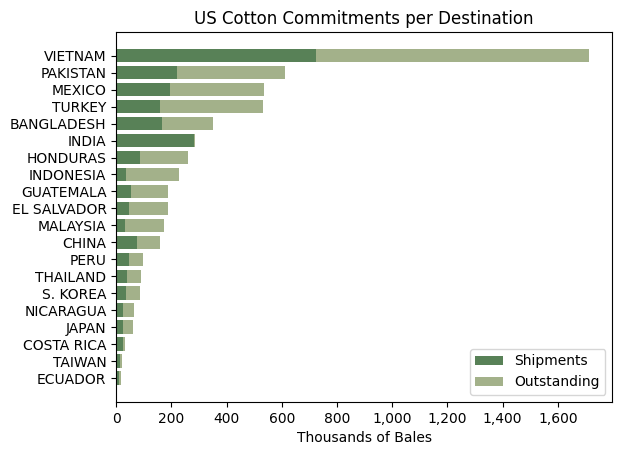

In [11]:
country = acc_per_country["countryDescription"][-20::]
shipped = acc_per_country["accumulatedExports"][-20::]/1000
outst_sales = acc_per_country["outstandingSales"][-20::]/1000

fig, ax = plt.subplots()
p1 = plt.barh(country, shipped, color="#588157")
p2 = plt.barh(country, outst_sales, left=shipped, color="#a3b18a")

plt.legend((p1[0], p2[0]), ('Shipments', 'Outstanding'))
plt.xlabel("Thousands of Bales")
plt.title("US Cotton Commitments per Destination")

import matplotlib.ticker as mtick
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))

# Seasonal Plot

Obtaining latest WASDE export forecast. This will be part of the plot.

In [12]:
#WASDE latest export forecast

#PSD (Production, Supply, and Distribution Forecast Data of World Ag Commodities) Codes
PSD_cotton = 2631000
PSD_US = "US"
Year = datetime.today().year
Exports_ID = 88


# PSD API request
url = f"https://api.fas.usda.gov/api/psd/commodity/{PSD_cotton}/country/US/year/{Year}"

# Headers are like labels on an envelope
headers = {
    'X-Api-Key': API_key,
    'accept': 'application/json'
}

# Send GET request
response = requests.get(url, headers=headers)

data_2 = response.json()
wasde_data = pd.DataFrame(data_2)

latest_export_forecast = wasde_data[wasde_data["attributeId"] == 88]
wasde_export = latest_export_forecast["value"].iloc[0]*1000

Defining a function that sends the API request for a specified years interval

In [13]:
data_6y = df_totals[['weekEndingDate', 'accumulatedExports', 'outstandingSales']]
weekly_totals = data_6y.groupby('weekEndingDate')[['accumulatedExports', 'outstandingSales']].sum().reset_index()
weekly_totals["MY"] = (
    weekly_totals["weekEndingDate"].dt.year
    + (
        (weekly_totals["weekEndingDate"].dt.month > 8)
        | (
            (weekly_totals["weekEndingDate"].dt.month == 8)
            & (weekly_totals["weekEndingDate"].dt.day >= 6)
        )
    ).astype(int)
)


In [14]:
weekly_totals = weekly_totals.sort_values(["MY", "weekEndingDate"])
weekly_totals["MktingWeek"] = (weekly_totals.groupby("MY").cumcount() + 1)

Finally: Plotting

In [15]:
week_to_month = {
    1: 'Aug', 2: 'Aug', 3: 'Aug', 4: 'Aug',
    5: 'Sep', 6: 'Sep', 7: 'Sep', 8: 'Sep',
    9: 'Oct', 10: 'Oct', 11: 'Oct', 12: 'Oct',
    13: 'Nov', 14: 'Nov', 15: 'Nov', 16: 'Nov',
    17: 'Dec', 18: 'Dec', 19: 'Dec', 20: 'Dec',
    21: 'Jan', 22: 'Jan', 23: 'Jan', 24: 'Jan',
    25: 'Feb', 26: 'Feb', 27: 'Feb', 28: 'Feb',
    29: 'Mar', 30: 'Mar', 31: 'Mar', 32: 'Mar',
    33: 'Apr', 34: 'Apr', 35: 'Apr', 36: 'Apr',
    37: 'May', 38: 'May', 39: 'May', 40: 'May',
    41: 'Jun', 42: 'Jun', 43: 'Jun', 44: 'Jun',
    45: 'Jul', 46: 'Jul', 47: 'Jul', 48: 'Jul',
    49: 'Jul', 50: 'Jul', 51: 'Jul', 52: 'Jul'
}

weeks = np.arange(1, 53)
month_labels = [week_to_month[w] for w in weeks]

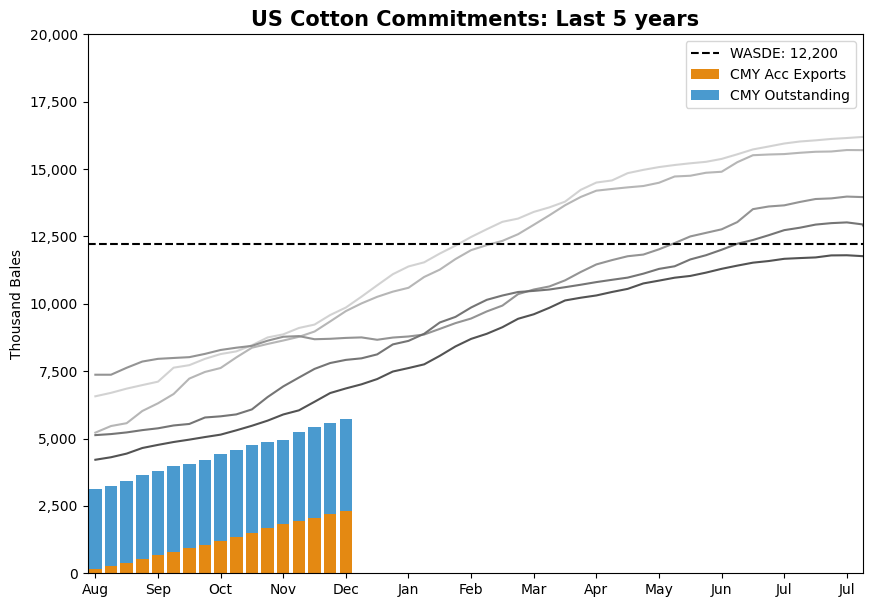

In [16]:
import matplotlib.cm as cm

# CMY bars
# Defining Current Marketing Year
if datetime.today().month < 8:
    CMY = datetime.today().year
else:
    CMY = datetime.today().year + 1

cmy_df = weekly_totals[weekly_totals["MY"] == CMY].sort_values("MktingWeek")

fig, ax = plt.subplots(figsize=(10,7))

ax.bar(cmy_df["MktingWeek"], cmy_df["accumulatedExports"], label=f"CMY Acc Exports", color = "#E48912")
ax.bar(cmy_df["MktingWeek"], cmy_df["outstandingSales"],
       bottom=cmy_df["accumulatedExports"], label=f"CMY Outstanding", color = "#4A9ACF")

# Prior 5 MY lines (pick what you want to plot as the line; here: total commitments)
prev_years = [y for y in sorted(weekly_totals["MY"].unique()) if y < CMY][-5:]
colors = cm.Greys(np.linspace(0.3, 0.8, len(prev_years)))

for y, c in zip(prev_years, colors):
    d = weekly_totals[weekly_totals["MY"] == y].sort_values("MktingWeek")
    total = d["accumulatedExports"] + d["outstandingSales"]
    ax.plot(d["MktingWeek"], total, color=c, linewidth=1.5, alpha=0.9)

# Replace x-ticks with month labels
plt.xticks(ticks=weeks[::4], labels=month_labels[::4])  # Show every 4th week for readability

# Add wasde export forecast
plt.axhline(
    y=wasde_export,
    color="black",
    linestyle="--",
    label=f"WASDE: {wasde_export/1e3:,.0f}"
)

ax.set_xlim(0.5,50)
ax.set_ylim(0,20_000_000)

ax.set_title("US Cotton Commitments: Last 5 years", fontsize=15, fontweight="bold")
ax.set_ylabel("Thousand Bales")
ax.legend()


ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e3:,.0f}"))


# Calc. how many bales/week (or tons/week) in sales are needed to match WASDE's latest Exports figure

Start by calculating number of weeks left on CMY

In [17]:
from datetime import timedelta


# Defining end date for CMY
end_day = 31
end_month = 7
if datetime.today().month in np.arange(1,8):
    end_year = datetime.today().year
else:
    end_year = datetime.today().year + 1

start = datetime(latest.year, latest.month, latest.day)
end = datetime(end_year, end_month, end_day)


# N of weeks left from latest ESR report to end of CMY
delta = end - start
weeks_left_CMY = int(delta.days/7)


We can now finally calculate the average number of bales the US needs to sell to reach the number on the WASDE report

In [18]:
commitments = last_week[["currentMYTotalCommitment"]].sum()

need_to_sell = wasde_export - commitments
avg_fut_sales = need_to_sell/weeks_left_CMY

fwd_sales_data = {"CMY Commitments" : commitments,
                  "WASDE Exports": wasde_export,
                  "N. of Weeks Left CMY": weeks_left_CMY,
                  "Avg. Weekly Sales Needed": avg_fut_sales}

fwd_sales_df = pd.DataFrame(fwd_sales_data)

#Formatting and displaying table
# 1) Drop index
fwd_sales_df.index = ['']

# 2) Make Avg Weekly Sales Needed an integer
fwd_sales_df["Avg. Weekly Sales Needed"] = (
    fwd_sales_df["Avg. Weekly Sales Needed"].astype(int)
)

# 3) Format numbers in millions + "M"
def fmt_millions(x):
    if isinstance(x, (int, float)):
        return f"{x/1_000_000:.2f}M"
    return x

cols_to_format = ["CMY Commitments", "WASDE Exports", "Avg. Weekly Sales Needed"]

fwd_sales_df[cols_to_format] = (
    fwd_sales_df[cols_to_format]
    .apply(lambda col: col.map(fmt_millions))
)

fwd_sales_df

,CMY Commitments,WASDE Exports,N. of Weeks Left CMY,Avg. Weekly Sales Needed
,5.72M,12.20M,35,0.19M
